# AUDIO CLASSIFICATION WITH MLP

In this exercise it has been used a dataset from kaggle that contains the speeches of these famous leaders, which include Benjamin Netanyahu, Jens Stoltenberg, Julia Gillard, Margaret Tacher and Nelson Mandela. They also represent the names of the folders and each audio in the folder is a one second long PCM with a sample rate of 16000hz encoded. 

https://www.kaggle.com/kongaevans/speaker-recognition-dataset/

The objective of the exercise is to use the MLP to identify the person that is speaking from a 1 sec audio. 

In [1]:
import zipfile
import os

# Path to the zip file downloaded from Kaggle
zip_file_path = r"C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches.zip"

# Path where you want to extract the dataset
extraction_directory = r"C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets"

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print("Extraction complete.")


Extraction complete.


## PART 1

In [6]:
import os

DATASET_ROOT = DATASET_ROOT = r"C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

In [7]:
import IPython.display as ipd

ipd.Audio(os.path.join(BENJAMIN_DATA, "22.wav"))

In [10]:
import librosa

wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, "22.wav"))

In [11]:
print(wav)

[ 0.0378246   0.07599634  0.14084503 ... -0.01175935  0.01080641
  0.01450372]


In [12]:
print(sr)

22050


Librosa's load method returns two results:

- It returns the wave that represents the sound that we are loading in the context of our Jupyter Notebook.
- It returns the sampling ratio.

Sound is an analog signal, in order to make it digital and represent it numerically we have to sample the original signal.
The Nyquist-Shannon sampling theorem showed that if our sampling rate is high enough, we are able to capture all the signal information and even recover it completely.

In [13]:
# with the sampling rate and the total size of the signal we can get the audio length 
long_audio = len(wav)/sr
print("Audio length in seconds:", long_audio)

Audio length in seconds: 1.0


We can represent our sound wave to visualize it better.

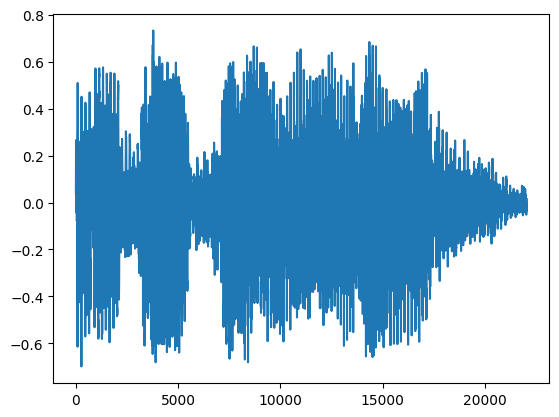

In [14]:
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

### Data preparation

In [15]:
def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            X.append(wav)
            y.append(index)
    return (X, y)

In [16]:
X, y = parse_dataset([BENJAMIN_DATA, JENS_DATA])
#we get only two person's data to make it a binary problem

[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Jens_Stoltenberg data...


In [17]:
print(len(X))

3000


In [18]:
### We divide the dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [19]:
print("Length train set: ", len(X_train))
print("Length test set: ", len(X_test))

Length train set:  2850
Length test set:  150


### Modelling 

In [20]:
# we train a MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train, y_train)

C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [21]:
y_pred = clf.predict(X_test) # we predict with the test set

In [22]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="binary") 


0.5806451612903226

The score obtained isn't by far the best one, the algorithm works nearly at random.

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)  

# We double check with the confusion matrix, there are a lof of false postives and false negatives

array([[40, 31],
       [34, 45]], dtype=int64)

We have to process a bit more the sound data and represent it in another way (not only with the sampling rate) in order to make better predictions. Let's try it out.

## PART II

We will represent the sound as an spectogram. 
We will try to represent the signals based on the frequency they are composed of. Each sound (the human voice included) is composed of a lot of cosenus waves in different frequencies. The spectogram is the representation of the extracted frequencies that we'll use to feed our algorithm.

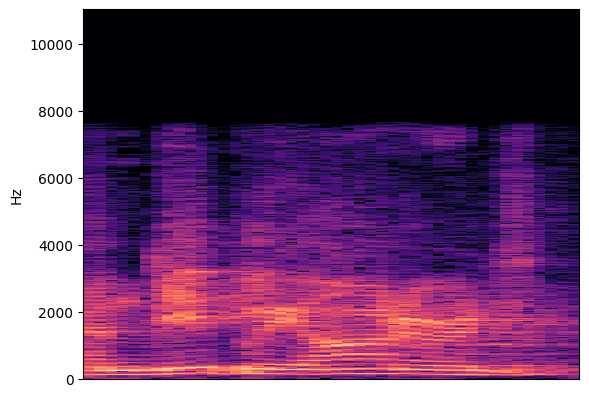

In [33]:
import numpy as np

# Represent the spectogram

import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.show()

When the spectogram is clearer it means there is more sound intensity.

### Data preparation

In [42]:
import librosa

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [43]:
# X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])
X_prep, y_prep = parse_dataset([JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA]) #we can decide how many people to predict their voices

[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Julia_Gillard data...
[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing C:\Users\Ihona\Desktop\Hands-on-ML\Hands-on-ML\Part II - Neural networks and DL\Perceptron\Datasets\16000_pcm_speeches\Nelson_Mandela data...


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [45]:
print(len(X_train))
print(len(X_test))

5700
301


In [46]:
X_train_prep[0]

array([-0.13109292, -0.15083924, -0.22644384, ..., -0.3137255 ,
       -0.26300552, -0.22770198], dtype=float32)

### Modelling

In [47]:
import numpy as np

X_train_prep = np.array(X_train).reshape((len(X_train), 1025*32))
X_train_prep = np.array(X_train_prep).astype('float32') / 255  # Normalize the entries
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 1025*32))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [48]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train_prep)

C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [49]:
y_pred = clf.predict(X_test_prep)

In [50]:
from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="binary")
f1_score(y_test, y_pred, average="weighted")

0.9634680176732983